In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from scipy import stats
from scipy import interpolate
import matplotlib.cm as cm
import numpy.polynomial.polynomial as poly  
%matplotlib inline

In [2]:
df = pd.read_csv('../WORK/surf_bT_ret_171031.txt', header=None, delimiter=r"\s+", names = [' ', 'UTC', 'MY', 'L_s', 'LTST', 'Surf_lat', 'Surf_lon', 'Surf_rad', 'Surf_elev', 'T_surf', 'T_surf_err', 'Dust_column', 'Dust_column_err', 'H2Oice_column', 'H2Oice_column_err', 'p_surf', 'p_surf_err', 'P_qual', 'T_qual'])
#read data into dataframe

The above reads the text file into a dataframe

In [3]:
########
# pco2 #
########
# --------------------------------------------
# Equilibrium vapor pressure over solid CO2
# Brown and Ziegler (1980)
# --------------------------------------------
# Input:
#    T = temperature of solid [K]
# Output:
#    vapor pressure [Pa]
def pco2(T):
    A0 = 2.13807649e1
    A1 = -2.57064700e3
    A2 = -7.78129489e4
    A3 = 4.32506256e6
    A4 = -1.20671368e8
    A5 = 1.34966306e9
    # Pressure in torr
    ptorr = np.exp(A0 + (A1/(T)) + (A2/(T**2)) + (A3/(T**3)) + (A4/(T**4)) + (A5/(T**5)))
    # Pressure in Pa
    p = ptorr*133.3223684211
    return p

In [4]:
########
# tco2 #
########
#-------------------------------------------------------------------------
#Calculate (approximately) the condensation temperature of CO2 at the
#specified pressure(s) (Pa), using the empirical law from Brown and 
#Ziegler (1980). This function calls the pco2() routine.
#-------------------------------------------------------------------------
# Input:
#    p = vapor pressure [Pa]
# Output:
#    temperature of solid [K]
def tco2(p):
    Trange = np.arange(30,350)
    T = interpolate.pchip_interpolate(pco2(Trange),Trange,p)
    return T

Both Formulas above are to calculate the equilibrium vapor pressure and temperature for carbon dioxide

In [5]:
# Function: ls2sol
# Purpose: convert Mars "Lsubs" to sol (day of year)
# Input: 
#    ls = areocentric longitude of the Sun [array]
#    n = degree of polynomial fit [scalar]
def ls2sol(ls, n):
    # data
    lsdata = (0,30,60,90,120,150,180,210,240,270,300,330,360) # L_s array
    soldata = (0,61.2,126.6,193.3,257.8,317.5,371.9,421.6,468.5,514.6,562.0,612.9,668.6) # Sol array
    
    # polynomial fit
    p = np.polyfit(lsdata, soldata, n)
    
    # sol for Ls input
    sol = np.polyval(p, ls)
    
    # return result
    return sol

Formula to convert solar longitude to Sols

In [6]:
df['Sol'] = ls2sol(df['L_s'],8)
dfday = df[df['LTST'] >= .5]
dfnight = df[df['LTST'] <= .5]

In [7]:
cond = (df['MY'],df['L_s'],pco2(df['T_surf']), df['p_surf'], tco2(df['p_surf']), df['T_surf'], df['LTST'], df['Surf_lat'], df['Surf_lon'], df['Dust_column'] , df['Sol'] )
cond_right= np.transpose(cond)
CO2 = pd.DataFrame(list(cond_right))
CO2.columns = ['MY','L_s','Eq_Vap_P','p_surf','Eq_Vap_T','T_surf','LTST', 'Surf_lat', 'Surf_lon', 'Dust_column', 'Sol']

In [8]:
newCO2 = CO2[CO2['Eq_Vap_P'] <= CO2['p_surf']]

In [9]:
CO2day = CO2[CO2['LTST'] >= 0.5]
CO2night = CO2[CO2['LTST'] <= 0.5]

In [12]:
def MYretrieval(dataframe, MY):
    if MY == '28':
        return dataframe[(dataframe['MY'] == 28)]
    elif MY == '29':
        return dataframe[(dataframe['MY'] == 29)]
    elif MY == '30':
        return dataframe[(dataframe['MY'] == 30)]
    elif MY == '31':
        return dataframe[(dataframe['MY'] == 31)]
    elif MY == '32':
        return dataframe[(dataframe['MY'] == 32)]
    elif MY == '33':
        return dataframe[(dataframe['MY'] == 33)]
    elif MY == '34':
        return dataframe[(dataframe['MY'] == 34)]
    elif MY == '35':
        return dataframe[(dataframe['MY'] == 35)]

In [15]:
def CreateSubFrame(MarsDF, RanL_s, RanLat, RanLong):
    '''Function to divide previously created data frames in smaller data frames by providing ranges
    Input:
    MarsYearDF: Mars Data frames 
    RanL_s: range of Solar Longitude example [0,360]
    RanAlbedo: Albedo Range example [0.5,1.0]
    RanSZA Solar Zenith angle range example [0,45]
    RanLat and RanLong are set as default
    Output: Several Subframes'''
    L_s_MYDF = MarsDF['L_s']
    Lat_MYDF = MarsDF['Surf_lat']
    Long_MYDF = MarsDF['Surf_lon']
    MY_SUB = MarsDF[(L_s_MYDF <= RanL_s[-1])  & (L_s_MYDF >= RanL_s[0]) &
                        (Lat_MYDF <= RanLat[-1] ) & (Lat_MYDF >= RanLat[0]) & 
                        (Long_MYDF <= RanLong[-1]) & (Long_MYDF >= RanLong[0])]
    return MY_SUB

In [17]:
def column(MYDict, Parameter):
    '''Function to run statistics on data on the subframes from the dictionaries created by the SubDict function
    Input:
    MYDict: Dictionary Created by the SubDict Function
    Output:
    SubAvg: Average of the Albedo for each subframe in the dictionary
    SubStd: Standard Deviation of the Albedo for each subframe in the dictionary
    Sub_L_s: Average of the  Solar Longitude range for each subframe in the dictionary'''
    SubframeNum = len(MYDict.keys())
    SubTemp = []
    SubPres =[]
    SubMY = []
    SubLat =[]
    SubLong = []
    SubDust =[]
    SubSol = []
    SubStr = 'DataFrame{}'
    for i in range(SubframeNum):
        Subframe = MYDict[SubStr.format(i)]
        SubTemp.append((Subframe['T_surf'].values))
        SubPres.append((Subframe['p_surf'].values))
        SubMY.append((Subframe['MY'].values))
        SubLat.append((Subframe['Surf_lat'].values))
        SubLong.append((Subframe['Surf_lon'].values))
        SubDust.append((Subframe['Dust_column'].values))
        SubSol.append((Subframe['Sol'].values))
    SubTemp = np.array(SubTemp)
    SubPres = np.array(SubPres)
    SubMY = np.array(SubMY)
    SubLat = np.array(SubLat)
    SubLong = np.array(SubLong)
    SubDust = np.array(SubDust)
    SubSol = np.array(SubSol)
    if Parameter =='Temperature':
        return SubTemp
    elif Parameter =='Pressure': 
        return SubPres
    elif Parameter =='Martian Year':
        return SubMY 
    elif Parameter =='Latitude':
        return SubLat 
    elif Parameter =='Longitude':
        return SubLong
    elif Parameter =='Dust Column':
        return SubDust
    elif Parameter =='Sol':
        return SubSol 

In [18]:
def IRFlux(T):
    '''Calculate the luminosity of the thing.'''
    sigma = 5.67e-8 # W/m**2/K**4
    boltz = sigma * T**4
    return boltz

In [19]:
dfday28 = MYretrieval(dfday, '28')
dfday29 = MYretrieval(dfday, '29')
dfday30 = MYretrieval(dfday, '30')
dfday31 = MYretrieval(dfday, '31')
dfday32 = MYretrieval(dfday, '32')
dfday33 = MYretrieval(dfday, '33')
dfday34 = MYretrieval(dfday, '34')
dfday35 = MYretrieval(dfday, '35')

dfnight28 = MYretrieval(dfnight, '28')
dfnight29 = MYretrieval(dfnight, '29')
dfnight30 = MYretrieval(dfnight, '30')
dfnight31 = MYretrieval(dfnight, '31')
dfnight32 = MYretrieval(dfnight, '32')
dfnight33 = MYretrieval(dfnight, '33')
dfnight34 = MYretrieval(dfnight, '34')
dfnight35 = MYretrieval(dfnight, '35')

CO2day28 = MYretrieval(CO2day, '28')
CO2day29 = MYretrieval(CO2day, '29')
CO2day30 = MYretrieval(CO2day, '30')
CO2day31 = MYretrieval(CO2day, '31')
CO2day32 = MYretrieval(CO2day, '32')
CO2day33 = MYretrieval(CO2day, '33')
CO2day34 = MYretrieval(CO2day, '34')
CO2day35 = MYretrieval(CO2day, '35')

CO2night28 = MYretrieval(CO2night, '28')
CO2night29 = MYretrieval(CO2night, '29')
CO2night30 = MYretrieval(CO2night, '30')
CO2night31 = MYretrieval(CO2night, '31')
CO2night32 = MYretrieval(CO2night, '32')
CO2night33 = MYretrieval(CO2night, '33')
CO2night34 = MYretrieval(CO2night, '34')
CO2night35 = MYretrieval(CO2night, '35')

In [68]:
Lyot_SubframesDayMY28 = CreateSubFrame(dfday28, RanL_s=np.linspace(0,360), RanLat=np.linspace(48.8,52.8), RanLong=np.linspace(-27.3,-25.3))
Lyot_SubframesDayMY29 = CreateSubFrame(dfday29, RanL_s=np.linspace(0,360), RanLat=np.linspace(48.8,52.8), RanLong=np.linspace(-27.3,-25.3))
Lyot_SubframesDayMY30 = CreateSubFrame(dfday30, RanL_s=np.linspace(0,360), RanLat=np.linspace(48.8,52.8), RanLong=np.linspace(-27.3,-25.3))
Lyot_SubframesDayMY31 = CreateSubFrame(dfday31, RanL_s=np.linspace(0,360), RanLat=np.linspace(48.8,52.8), RanLong=np.linspace(-27.3,-25.3))
Lyot_SubframesDayMY32 = CreateSubFrame(dfday32, RanL_s=np.linspace(0,360), RanLat=np.linspace(48.8,52.8), RanLong=np.linspace(-27.3,-25.3))
Lyot_SubframesDayMY33 = CreateSubFrame(dfday33, RanL_s=np.linspace(0,360), RanLat=np.linspace(48.8,52.8), RanLong=np.linspace(-27.3,-25.3))
Lyot_SubframesDayMY34 = CreateSubFrame(dfday34, RanL_s=np.linspace(0,360), RanLat=np.linspace(48.8,52.8), RanLong=np.linspace(-27.3,-25.3))

Lyot_SubframesNightMY28 = CreateSubFrame(dfnight28, RanL_s=np.linspace(0,360), RanLat=np.linspace(48.8,52.8), RanLong=np.linspace(-27.3,-25.3))
Lyot_SubframesNightMY29 = CreateSubFrame(dfnight29, RanL_s=np.linspace(0,360), RanLat=np.linspace(48.8,52.8), RanLong=np.linspace(-27.3,-25.3))
Lyot_SubframesNightMY30 = CreateSubFrame(dfnight30, RanL_s=np.linspace(0,360), RanLat=np.linspace(48.8,52.8), RanLong=np.linspace(-27.3,-25.3))
Lyot_SubframesNightMY31 = CreateSubFrame(dfnight31, RanL_s=np.linspace(0,360), RanLat=np.linspace(48.8,52.8), RanLong=np.linspace(-27.3,-25.3))
Lyot_SubframesNightMY32 = CreateSubFrame(dfnight32, RanL_s=np.linspace(0,360), RanLat=np.linspace(48.8,52.8), RanLong=np.linspace(-27.3,-25.3))
Lyot_SubframesNightMY33 = CreateSubFrame(dfnight33, RanL_s=np.linspace(0,360), RanLat=np.linspace(48.8,52.8), RanLong=np.linspace(-27.3,-25.3))
Lyot_SubframesNightMY34 = CreateSubFrame(dfnight34, RanL_s=np.linspace(0,360), RanLat=np.linspace(48.8,52.8), RanLong=np.linspace(-27.3,-25.3))

Lyot_CO2day28 = CreateSubFrame(CO2day28, RanL_s=np.linspace(0,360), RanLat=np.linspace(48.8,52.8), RanLong=np.linspace(-27.3,-25.3))
Lyot_CO2day29 = CreateSubFrame(CO2day29, RanL_s=np.linspace(0,360), RanLat=np.linspace(48.8,52.8), RanLong=np.linspace(-27.3,-25.3))
Lyot_CO2day30 = CreateSubFrame(CO2day30, RanL_s=np.linspace(0,360), RanLat=np.linspace(48.8,52.8), RanLong=np.linspace(-27.3,-25.3))
Lyot_CO2day31 = CreateSubFrame(CO2day31, RanL_s=np.linspace(0,360), RanLat=np.linspace(48.8,52.8), RanLong=np.linspace(-27.3,-25.3))
Lyot_CO2day32 = CreateSubFrame(CO2day32, RanL_s=np.linspace(0,360), RanLat=np.linspace(48.8,52.8), RanLong=np.linspace(-27.3,-25.3))
Lyot_CO2day33 = CreateSubFrame(CO2day33, RanL_s=np.linspace(0,360), RanLat=np.linspace(48.8,52.8), RanLong=np.linspace(-27.3,-25.3))
Lyot_CO2day34 = CreateSubFrame(CO2day34, RanL_s=np.linspace(0,360), RanLat=np.linspace(48.8,52.8), RanLong=np.linspace(-27.3,-25.3))

Lyot_CO2night28 = CreateSubFrame(CO2night28, RanL_s=np.linspace(0,360), RanLat=np.linspace(48.8,52.8), RanLong=np.linspace(-27.3,-25.3))
Lyot_CO2night29 = CreateSubFrame(CO2night29, RanL_s=np.linspace(0,360), RanLat=np.linspace(48.8,52.8), RanLong=np.linspace(-27.3,-25.3))
Lyot_CO2night30 = CreateSubFrame(CO2night30, RanL_s=np.linspace(0,360), RanLat=np.linspace(48.8,52.8), RanLong=np.linspace(-27.3,-25.3))
Lyot_CO2night31 = CreateSubFrame(CO2night31, RanL_s=np.linspace(0,360), RanLat=np.linspace(48.8,52.8), RanLong=np.linspace(-27.3,-25.3))
Lyot_CO2night32 = CreateSubFrame(CO2night32, RanL_s=np.linspace(0,360), RanLat=np.linspace(48.8,52.8), RanLong=np.linspace(-27.3,-25.3))
Lyot_CO2night33 = CreateSubFrame(CO2night33, RanL_s=np.linspace(0,360), RanLat=np.linspace(48.8,52.8), RanLong=np.linspace(-27.3,-25.3))
Lyot_CO2night34 = CreateSubFrame(CO2night34, RanL_s=np.linspace(0,360), RanLat=np.linspace(48.8,52.8), RanLong=np.linspace(-27.3,-25.3))

In [50]:
Lyot_SubframesDay = pd.concat([Lyot_SubframesDayMY28,
                              Lyot_SubframesDayMY29,
                              Lyot_SubframesDayMY30,
                              Lyot_SubframesDayMY31,
                              Lyot_SubframesDayMY32,
                              Lyot_SubframesDayMY33,
                              Lyot_SubframesDayMY34])

In [51]:
Lyot_SubframesDay = Lyot_SubframesDay.drop([' ','UTC'], axis=1)

In [52]:
Lyot_SubframesDay.to_csv('Lyot Crater MCS Data Day', sep=' ')

In [46]:
Lyot_SubframesNight = pd.concat([Lyot_SubframesNightMY28,
                              Lyot_SubframesNightMY29,
                              Lyot_SubframesNightMY30,
                              Lyot_SubframesNightMY31,
                              Lyot_SubframesNightMY32,
                              Lyot_SubframesNightMY33,
                              Lyot_SubframesNightMY34])

In [47]:
Lyot_SubframesNight = Lyot_SubframesNight.drop([' ','UTC'], axis=1)
Lyot_SubframesNight.to_csv('Lyot Crater MCS Data Night', sep=' ')

In [ ]:
135.912

In [72]:
F9_SubframesDayMY28 = CreateSubFrame(dfday28, RanL_s=np.linspace(0,360), RanLat=np.linspace(64.031,65.031), RanLong=np.linspace(135.412,136.412))
F9_SubframesDayMY29 = CreateSubFrame(dfday29, RanL_s=np.linspace(0,360), RanLat=np.linspace(64.031,65.031), RanLong=np.linspace(135.412,136.412))
F9_SubframesDayMY30 = CreateSubFrame(dfday30, RanL_s=np.linspace(0,360), RanLat=np.linspace(64.031,65.031), RanLong=np.linspace(135.412,136.412))
F9_SubframesDayMY31 = CreateSubFrame(dfday31, RanL_s=np.linspace(0,360), RanLat=np.linspace(64.031,65.031), RanLong=np.linspace(135.412,136.412))
F9_SubframesDayMY32 = CreateSubFrame(dfday32, RanL_s=np.linspace(0,360), RanLat=np.linspace(64.031,65.031), RanLong=np.linspace(135.412,136.412))
F9_SubframesDayMY33 = CreateSubFrame(dfday33, RanL_s=np.linspace(0,360), RanLat=np.linspace(64.031,65.031), RanLong=np.linspace(135.412,136.412))
F9_SubframesDayMY34 = CreateSubFrame(dfday34, RanL_s=np.linspace(0,360), RanLat=np.linspace(64.031,65.031), RanLong=np.linspace(135.412,136.412))

F9_SubframesNightMY28 = CreateSubFrame(dfnight28, RanL_s=np.linspace(0,360), RanLat=np.linspace(64.031,65.031), RanLong=np.linspace(135.412,136.412))
F9_SubframesNightMY29 = CreateSubFrame(dfnight29, RanL_s=np.linspace(0,360), RanLat=np.linspace(64.031,65.031), RanLong=np.linspace(135.412,136.412))
F9_SubframesNightMY30 = CreateSubFrame(dfnight30, RanL_s=np.linspace(0,360), RanLat=np.linspace(64.031,65.031), RanLong=np.linspace(135.412,136.412))
F9_SubframesNightMY31 = CreateSubFrame(dfnight31, RanL_s=np.linspace(0,360), RanLat=np.linspace(64.031,65.031), RanLong=np.linspace(135.412,136.412))
F9_SubframesNightMY32 = CreateSubFrame(dfnight32, RanL_s=np.linspace(0,360), RanLat=np.linspace(64.031,65.031), RanLong=np.linspace(135.412,136.412))
F9_SubframesNightMY33 = CreateSubFrame(dfnight33, RanL_s=np.linspace(0,360), RanLat=np.linspace(64.031,65.031), RanLong=np.linspace(135.412,136.412))
F9_SubframesNightMY34 = CreateSubFrame(dfnight34, RanL_s=np.linspace(0,360), RanLat=np.linspace(64.031,65.031), RanLong=np.linspace(135.412,136.412))

F9_CO2day28 = CreateSubFrame(CO2day28, RanL_s=np.linspace(0,360), RanLat=np.linspace(64.031,65.031), RanLong=np.linspace(135.412,136.412))
F9_CO2day29 = CreateSubFrame(CO2day29, RanL_s=np.linspace(0,360), RanLat=np.linspace(64.031,65.031), RanLong=np.linspace(135.412,136.412))
F9_CO2day30 = CreateSubFrame(CO2day30, RanL_s=np.linspace(0,360), RanLat=np.linspace(64.031,65.031), RanLong=np.linspace(135.412,136.412))
F9_CO2day31 = CreateSubFrame(CO2day31, RanL_s=np.linspace(0,360), RanLat=np.linspace(64.031,65.031), RanLong=np.linspace(135.412,136.412))
F9_CO2day32 = CreateSubFrame(CO2day32, RanL_s=np.linspace(0,360), RanLat=np.linspace(64.031,65.031), RanLong=np.linspace(135.412,136.412))
F9_CO2day33 = CreateSubFrame(CO2day33, RanL_s=np.linspace(0,360), RanLat=np.linspace(64.031,65.031), RanLong=np.linspace(135.412,136.412))
F9_CO2day34 = CreateSubFrame(CO2day34, RanL_s=np.linspace(0,360), RanLat=np.linspace(64.031,65.031), RanLong=np.linspace(135.412,136.412))

F9_CO2night28 = CreateSubFrame(CO2night28, RanL_s=np.linspace(0,360), RanLat=np.linspace(64.031,65.031), RanLong=np.linspace(135.412,136.412))
F9_CO2night29 = CreateSubFrame(CO2night29, RanL_s=np.linspace(0,360), RanLat=np.linspace(64.031,65.031), RanLong=np.linspace(135.412,136.412))
F9_CO2night30 = CreateSubFrame(CO2night30, RanL_s=np.linspace(0,360), RanLat=np.linspace(64.031,65.031), RanLong=np.linspace(135.412,136.412))
F9_CO2night31 = CreateSubFrame(CO2night31, RanL_s=np.linspace(0,360), RanLat=np.linspace(64.031,65.031), RanLong=np.linspace(135.412,136.412))
F9_CO2night32 = CreateSubFrame(CO2night32, RanL_s=np.linspace(0,360), RanLat=np.linspace(64.031,65.031), RanLong=np.linspace(135.412,136.412))
F9_CO2night33 = CreateSubFrame(CO2night33, RanL_s=np.linspace(0,360), RanLat=np.linspace(64.031,65.031), RanLong=np.linspace(135.412,136.412))
F9_CO2night34 = CreateSubFrame(CO2night34, RanL_s=np.linspace(0,360), RanLat=np.linspace(64.031,65.031), RanLong=np.linspace(135.412,136.412))

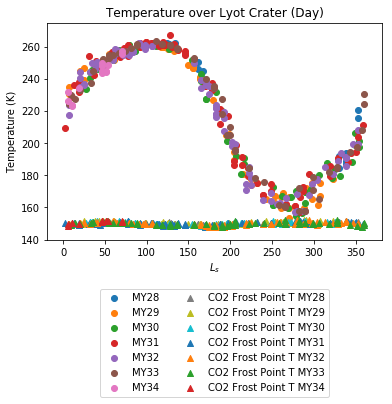

In [132]:
plt.scatter(Lyot_SubframesDayMY28['L_s'], Lyot_SubframesDayMY28['T_surf'], label = 'MY28')
plt.scatter(Lyot_SubframesDayMY29['L_s'], Lyot_SubframesDayMY29['T_surf'], label = 'MY29')
plt.scatter(Lyot_SubframesDayMY30['L_s'], Lyot_SubframesDayMY30['T_surf'], label = 'MY30')
plt.scatter(Lyot_SubframesDayMY31['L_s'], Lyot_SubframesDayMY31['T_surf'], label = 'MY31')
plt.scatter(Lyot_SubframesDayMY32['L_s'], Lyot_SubframesDayMY32['T_surf'], label = 'MY32')
plt.scatter(Lyot_SubframesDayMY33['L_s'], Lyot_SubframesDayMY33['T_surf'], label = 'MY33')
plt.scatter(Lyot_SubframesDayMY34['L_s'], Lyot_SubframesDayMY34['T_surf'], label = 'MY34')
plt.scatter(Lyot_CO2day28['L_s'],Lyot_CO2day28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.scatter(Lyot_CO2day29['L_s'],Lyot_CO2day29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.scatter(Lyot_CO2day30['L_s'],Lyot_CO2day30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.scatter(Lyot_CO2day31['L_s'],Lyot_CO2day31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.scatter(Lyot_CO2day32['L_s'],Lyot_CO2day32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.scatter(Lyot_CO2day33['L_s'],Lyot_CO2day33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.scatter(Lyot_CO2day34['L_s'],Lyot_CO2day34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.title('Temperature over Lyot Crater (Day)')
#plt.xlim(250,300)
#plt.ylim(130,180)
plt.show()

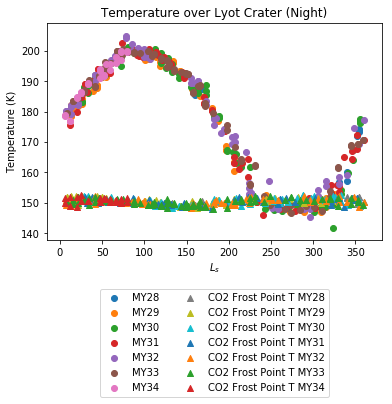

In [131]:
plt.scatter(Lyot_SubframesNightMY28['L_s'], Lyot_SubframesNightMY28['T_surf'], label = 'MY28')
plt.scatter(Lyot_SubframesNightMY29['L_s'], Lyot_SubframesNightMY29['T_surf'], label = 'MY29')
plt.scatter(Lyot_SubframesNightMY30['L_s'], Lyot_SubframesNightMY30['T_surf'], label = 'MY30')
plt.scatter(Lyot_SubframesNightMY31['L_s'], Lyot_SubframesNightMY31['T_surf'], label = 'MY31')
plt.scatter(Lyot_SubframesNightMY32['L_s'], Lyot_SubframesNightMY32['T_surf'], label = 'MY32')
plt.scatter(Lyot_SubframesNightMY33['L_s'], Lyot_SubframesNightMY33['T_surf'], label = 'MY33')
plt.scatter(Lyot_SubframesNightMY34['L_s'], Lyot_SubframesNightMY34['T_surf'], label = 'MY34')
plt.scatter(Lyot_CO2night28['L_s'],Lyot_CO2night28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.scatter(Lyot_CO2night29['L_s'],Lyot_CO2night29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.scatter(Lyot_CO2night30['L_s'],Lyot_CO2night30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.scatter(Lyot_CO2night31['L_s'],Lyot_CO2night31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.scatter(Lyot_CO2night32['L_s'],Lyot_CO2night32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.scatter(Lyot_CO2night33['L_s'],Lyot_CO2night33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.scatter(Lyot_CO2night34['L_s'],Lyot_CO2night34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Lyot Crater (Night)')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.show()

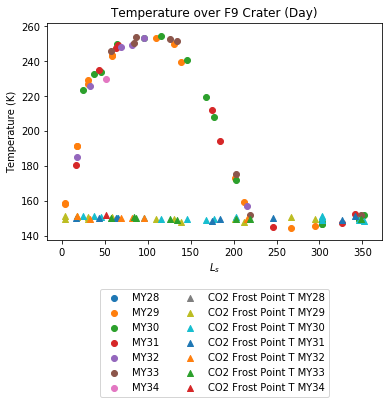

In [130]:
plt.scatter(F9_SubframesDayMY28['L_s'],F9_SubframesDayMY28['T_surf'], label = 'MY28')
plt.scatter(F9_SubframesDayMY29['L_s'],F9_SubframesDayMY29['T_surf'], label = 'MY29')
plt.scatter(F9_SubframesDayMY30['L_s'],F9_SubframesDayMY30['T_surf'], label = 'MY30')
plt.scatter(F9_SubframesDayMY31['L_s'],F9_SubframesDayMY31['T_surf'], label = 'MY31')
plt.scatter(F9_SubframesDayMY32['L_s'],F9_SubframesDayMY32['T_surf'], label = 'MY32')
plt.scatter(F9_SubframesDayMY33['L_s'],F9_SubframesDayMY33['T_surf'], label = 'MY33')
plt.scatter(F9_SubframesDayMY34['L_s'],F9_SubframesDayMY34['T_surf'], label = 'MY34')
plt.scatter(F9_CO2day28['L_s'],F9_CO2day28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.scatter(F9_CO2day29['L_s'],F9_CO2day29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.scatter(F9_CO2day30['L_s'],F9_CO2day30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.scatter(F9_CO2day31['L_s'],F9_CO2day31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.scatter(F9_CO2day32['L_s'],F9_CO2day32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.scatter(F9_CO2day33['L_s'],F9_CO2day33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.scatter(F9_CO2day34['L_s'],F9_CO2day34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.title('Temperature over F9 Crater (Day)')
#plt.xlim(250,300)
#plt.ylim(130,180)
plt.show()

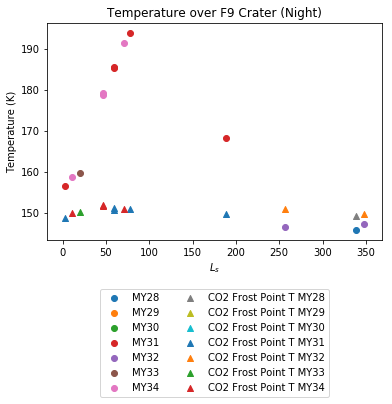

In [129]:
plt.scatter(F9_SubframesNightMY28['L_s'], F9_SubframesNightMY28['T_surf'], label = 'MY28')
plt.scatter(F9_SubframesNightMY29['L_s'], F9_SubframesNightMY29['T_surf'], label = 'MY29')
plt.scatter(F9_SubframesNightMY30['L_s'], F9_SubframesNightMY30['T_surf'], label = 'MY30')
plt.scatter(F9_SubframesNightMY31['L_s'], F9_SubframesNightMY31['T_surf'], label = 'MY31')
plt.scatter(F9_SubframesNightMY32['L_s'], F9_SubframesNightMY32['T_surf'], label = 'MY32')
plt.scatter(F9_SubframesNightMY33['L_s'], F9_SubframesNightMY33['T_surf'], label = 'MY33')
plt.scatter(F9_SubframesNightMY34['L_s'], F9_SubframesNightMY34['T_surf'], label = 'MY34')
plt.scatter(F9_CO2night28['L_s'],F9_CO2night28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.scatter(F9_CO2night29['L_s'],F9_CO2night29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.scatter(F9_CO2night30['L_s'],F9_CO2night30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.scatter(F9_CO2night31['L_s'],F9_CO2night31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.scatter(F9_CO2night32['L_s'],F9_CO2night32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.scatter(F9_CO2night33['L_s'],F9_CO2night33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.scatter(F9_CO2night34['L_s'],F9_CO2night34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.title('Temperature over F9 Crater (Night)')
plt.show()

In [38]:
F9_SubframesDay = pd.concat([F9_SubframesDayMY28,
                              F9_SubframesDayMY29,
                              F9_SubframesDayMY30,
                              F9_SubframesDayMY31,
                              F9_SubframesDayMY32,
                              F9_SubframesDayMY33,
                              F9_SubframesDayMY34])

In [40]:
F9_SubframesNight = pd.concat([F9_SubframesNightMY28,
                              F9_SubframesNightMY29,
                              F9_SubframesNightMY30,
                              F9_SubframesNightMY31,
                              F9_SubframesNightMY32,
                              F9_SubframesNightMY33,
                              F9_SubframesNightMY34])

In [86]:
Buzzel_SubframesDayMY28 = CreateSubFrame(dfday28, RanL_s=np.linspace(0,360), RanLat=np.linspace(83.5,84.5), RanLong=np.linspace(52.7,54.7))
Buzzel_SubframesDayMY29 = CreateSubFrame(dfday29, RanL_s=np.linspace(0,360), RanLat=np.linspace(83.5,84.5), RanLong=np.linspace(52.7,54.7))
Buzzel_SubframesDayMY30 = CreateSubFrame(dfday30, RanL_s=np.linspace(0,360), RanLat=np.linspace(83.5,84.5), RanLong=np.linspace(52.7,54.7))
Buzzel_SubframesDayMY31 = CreateSubFrame(dfday31, RanL_s=np.linspace(0,360), RanLat=np.linspace(83.5,84.5), RanLong=np.linspace(52.7,54.7))
Buzzel_SubframesDayMY32 = CreateSubFrame(dfday32, RanL_s=np.linspace(0,360), RanLat=np.linspace(83.5,84.5), RanLong=np.linspace(52.7,54.7))
Buzzel_SubframesDayMY33 = CreateSubFrame(dfday33, RanL_s=np.linspace(0,360), RanLat=np.linspace(83.5,84.5), RanLong=np.linspace(52.7,54.7))
Buzzel_SubframesDayMY34 = CreateSubFrame(dfday34, RanL_s=np.linspace(0,360), RanLat=np.linspace(83.5,84.5), RanLong=np.linspace(52.7,54.7))

Buzzel_SubframesNightMY28 = CreateSubFrame(dfnight28, RanL_s=np.linspace(0,360), RanLat=np.linspace(83.5,84.5), RanLong=np.linspace(52.7,54.7))
Buzzel_SubframesNightMY29 = CreateSubFrame(dfnight29, RanL_s=np.linspace(0,360), RanLat=np.linspace(83.5,84.5), RanLong=np.linspace(52.7,54.7))
Buzzel_SubframesNightMY30 = CreateSubFrame(dfnight30, RanL_s=np.linspace(0,360), RanLat=np.linspace(83.5,84.5), RanLong=np.linspace(52.7,54.7))
Buzzel_SubframesNightMY31 = CreateSubFrame(dfnight31, RanL_s=np.linspace(0,360), RanLat=np.linspace(83.5,84.5), RanLong=np.linspace(52.7,54.7))
Buzzel_SubframesNightMY32 = CreateSubFrame(dfnight32, RanL_s=np.linspace(0,360), RanLat=np.linspace(83.5,84.5), RanLong=np.linspace(52.7,54.7))
Buzzel_SubframesNightMY33 = CreateSubFrame(dfnight33, RanL_s=np.linspace(0,360), RanLat=np.linspace(83.5,84.5), RanLong=np.linspace(52.7,54.7))
Buzzel_SubframesNightMY34 = CreateSubFrame(dfnight34, RanL_s=np.linspace(0,360), RanLat=np.linspace(83.5,84.5), RanLong=np.linspace(52.7,54.7))

Buzzel_CO2day28 = CreateSubFrame(CO2day28, RanL_s=np.linspace(0,360), RanLat=np.linspace(83.5,84.5), RanLong=np.linspace(52.7,54.7))
Buzzel_CO2day29 = CreateSubFrame(CO2day29, RanL_s=np.linspace(0,360), RanLat=np.linspace(83.5,84.5), RanLong=np.linspace(52.7,54.7))
Buzzel_CO2day30 = CreateSubFrame(CO2day30, RanL_s=np.linspace(0,360), RanLat=np.linspace(83.5,84.5), RanLong=np.linspace(52.7,54.7))
Buzzel_CO2day31 = CreateSubFrame(CO2day31, RanL_s=np.linspace(0,360), RanLat=np.linspace(83.5,84.5), RanLong=np.linspace(52.7,54.7))
Buzzel_CO2day32 = CreateSubFrame(CO2day32, RanL_s=np.linspace(0,360), RanLat=np.linspace(83.5,84.5), RanLong=np.linspace(52.7,54.7))
Buzzel_CO2day33 = CreateSubFrame(CO2day33, RanL_s=np.linspace(0,360), RanLat=np.linspace(83.5,84.5), RanLong=np.linspace(52.7,54.7))
Buzzel_CO2day34 = CreateSubFrame(CO2day34, RanL_s=np.linspace(0,360), RanLat=np.linspace(83.5,84.5), RanLong=np.linspace(52.7,54.7))

Buzzel_CO2night28 = CreateSubFrame(CO2night28, RanL_s=np.linspace(0,360), RanLat=np.linspace(83.5,84.5), RanLong=np.linspace(52.7,54.7))
Buzzel_CO2night29 = CreateSubFrame(CO2night29, RanL_s=np.linspace(0,360), RanLat=np.linspace(83.5,84.5), RanLong=np.linspace(52.7,54.7))
Buzzel_CO2night30 = CreateSubFrame(CO2night30, RanL_s=np.linspace(0,360), RanLat=np.linspace(83.5,84.5), RanLong=np.linspace(52.7,54.7))
Buzzel_CO2night31 = CreateSubFrame(CO2night31, RanL_s=np.linspace(0,360), RanLat=np.linspace(83.5,84.5), RanLong=np.linspace(52.7,54.7))
Buzzel_CO2night32 = CreateSubFrame(CO2night32, RanL_s=np.linspace(0,360), RanLat=np.linspace(83.5,84.5), RanLong=np.linspace(52.7,54.7))
Buzzel_CO2night33 = CreateSubFrame(CO2night33, RanL_s=np.linspace(0,360), RanLat=np.linspace(83.5,84.5), RanLong=np.linspace(52.7,54.7))
Buzzel_CO2night34 = CreateSubFrame(CO2night34, RanL_s=np.linspace(0,360), RanLat=np.linspace(83.5,84.5), RanLong=np.linspace(52.7,54.7))

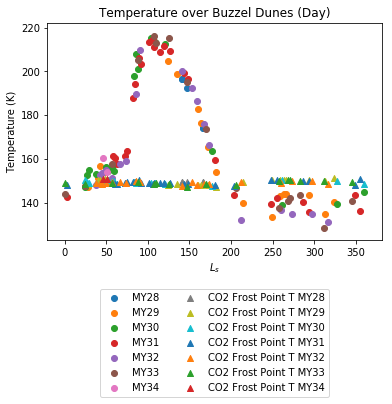

In [128]:
plt.scatter(Buzzel_SubframesDayMY28['L_s'], Buzzel_SubframesDayMY28['T_surf'], label = 'MY28')
plt.scatter(Buzzel_SubframesDayMY29['L_s'], Buzzel_SubframesDayMY29['T_surf'], label = 'MY29')
plt.scatter(Buzzel_SubframesDayMY30['L_s'], Buzzel_SubframesDayMY30['T_surf'], label = 'MY30')
plt.scatter(Buzzel_SubframesDayMY31['L_s'], Buzzel_SubframesDayMY31['T_surf'], label = 'MY31')
plt.scatter(Buzzel_SubframesDayMY32['L_s'], Buzzel_SubframesDayMY32['T_surf'], label = 'MY32')
plt.scatter(Buzzel_SubframesDayMY33['L_s'], Buzzel_SubframesDayMY33['T_surf'], label = 'MY33')
plt.scatter(Buzzel_SubframesDayMY34['L_s'], Buzzel_SubframesDayMY34['T_surf'], label = 'MY34')
plt.scatter(Buzzel_CO2day28['L_s'],Buzzel_CO2day28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.scatter(Buzzel_CO2day29['L_s'],Buzzel_CO2day29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.scatter(Buzzel_CO2day30['L_s'],Buzzel_CO2day30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.scatter(Buzzel_CO2day31['L_s'],Buzzel_CO2day31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.scatter(Buzzel_CO2day32['L_s'],Buzzel_CO2day32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.scatter(Buzzel_CO2day33['L_s'],Buzzel_CO2day33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.scatter(Buzzel_CO2day34['L_s'],Buzzel_CO2day34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.title('Temperature over Buzzel Dunes (Day)')
#plt.xlim(250,300)
#plt.ylim(130,180)
plt.show()

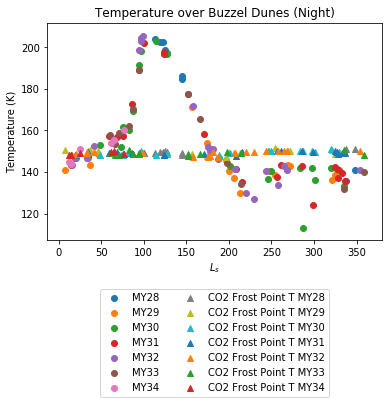

In [127]:
plt.scatter(Buzzel_SubframesNightMY28['L_s'], Buzzel_SubframesNightMY28['T_surf'], label = 'MY28')
plt.scatter(Buzzel_SubframesNightMY29['L_s'], Buzzel_SubframesNightMY29['T_surf'], label = 'MY29')
plt.scatter(Buzzel_SubframesNightMY30['L_s'], Buzzel_SubframesNightMY30['T_surf'], label = 'MY30')
plt.scatter(Buzzel_SubframesNightMY31['L_s'], Buzzel_SubframesNightMY31['T_surf'], label = 'MY31')
plt.scatter(Buzzel_SubframesNightMY32['L_s'], Buzzel_SubframesNightMY32['T_surf'], label = 'MY32')
plt.scatter(Buzzel_SubframesNightMY33['L_s'], Buzzel_SubframesNightMY33['T_surf'], label = 'MY33')
plt.scatter(Buzzel_SubframesNightMY34['L_s'], Buzzel_SubframesNightMY34['T_surf'], label = 'MY34')
plt.scatter(Buzzel_CO2night28['L_s'],Buzzel_CO2night28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.scatter(Buzzel_CO2night29['L_s'],Buzzel_CO2night29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.scatter(Buzzel_CO2night30['L_s'],Buzzel_CO2night30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.scatter(Buzzel_CO2night31['L_s'],Buzzel_CO2night31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.scatter(Buzzel_CO2night32['L_s'],Buzzel_CO2night32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.scatter(Buzzel_CO2night33['L_s'],Buzzel_CO2night33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.scatter(Buzzel_CO2night34['L_s'],Buzzel_CO2night34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Buzzel Dunes (Night)')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.show()

In [112]:
Kolhar_SubframesDayMY28 = CreateSubFrame(dfday28, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.2,85.2), RanLong=np.linspace(-180.3,-179.3))
Kolhar_SubframesDayMY29 = CreateSubFrame(dfday29, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.2,85.2), RanLong=np.linspace(-180.3,-179.3))
Kolhar_SubframesDayMY30 = CreateSubFrame(dfday30, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.2,85.2), RanLong=np.linspace(-180.3,-179.3))
Kolhar_SubframesDayMY31 = CreateSubFrame(dfday31, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.2,85.2), RanLong=np.linspace(-180.3,-179.3))
Kolhar_SubframesDayMY32 = CreateSubFrame(dfday32, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.2,85.2), RanLong=np.linspace(-180.3,-179.3))
Kolhar_SubframesDayMY33 = CreateSubFrame(dfday33, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.2,85.2), RanLong=np.linspace(-180.3,-179.3))
Kolhar_SubframesDayMY34 = CreateSubFrame(dfday34, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.2,85.2), RanLong=np.linspace(-180.3,-179.3))

Kolhar_SubframesNightMY28 = CreateSubFrame(dfnight28, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.2,85.2), RanLong=np.linspace(-180.3,-179.3))
Kolhar_SubframesNightMY29 = CreateSubFrame(dfnight29, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.2,85.2), RanLong=np.linspace(-180.3,-179.3))
Kolhar_SubframesNightMY30 = CreateSubFrame(dfnight30, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.2,85.2), RanLong=np.linspace(-180.3,-179.3))
Kolhar_SubframesNightMY31 = CreateSubFrame(dfnight31, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.2,85.2), RanLong=np.linspace(-180.3,-179.3))
Kolhar_SubframesNightMY32 = CreateSubFrame(dfnight32, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.2,85.2), RanLong=np.linspace(-180.3,-179.3))
Kolhar_SubframesNightMY33 = CreateSubFrame(dfnight33, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.2,85.2), RanLong=np.linspace(-180.3,-179.3))
Kolhar_SubframesNightMY34 = CreateSubFrame(dfnight34, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.2,85.2), RanLong=np.linspace(-180.3,-179.3))

Kolhar_CO2day28 = CreateSubFrame(CO2day28, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.2,85.2), RanLong=np.linspace(-180.3,-179.3))
Kolhar_CO2day29 = CreateSubFrame(CO2day29, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.2,85.2), RanLong=np.linspace(-180.3,-179.3))
Kolhar_CO2day30 = CreateSubFrame(CO2day30, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.2,85.2), RanLong=np.linspace(-180.3,-179.3))
Kolhar_CO2day31 = CreateSubFrame(CO2day31, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.2,85.2), RanLong=np.linspace(-180.3,-179.3))
Kolhar_CO2day32 = CreateSubFrame(CO2day32, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.2,85.2), RanLong=np.linspace(-180.3,-179.3))
Kolhar_CO2day33 = CreateSubFrame(CO2day33, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.2,85.2), RanLong=np.linspace(-180.3,-179.3))
Kolhar_CO2day34 = CreateSubFrame(CO2day34, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.2,85.2), RanLong=np.linspace(-180.3,-179.3))

Kolhar_CO2night28 = CreateSubFrame(CO2night28, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.2,85.2), RanLong=np.linspace(-180.3,-179.3))
Kolhar_CO2night29 = CreateSubFrame(CO2night29, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.2,85.2), RanLong=np.linspace(-180.3,-179.3))
Kolhar_CO2night30 = CreateSubFrame(CO2night30, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.2,85.2), RanLong=np.linspace(-180.3,-179.3))
Kolhar_CO2night31 = CreateSubFrame(CO2night31, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.2,85.2), RanLong=np.linspace(-180.3,-179.3))
Kolhar_CO2night32 = CreateSubFrame(CO2night32, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.2,85.2), RanLong=np.linspace(-180.3,-179.3))
Kolhar_CO2night33 = CreateSubFrame(CO2night33, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.2,85.2), RanLong=np.linspace(-180.3,-179.3))
Kolhar_CO2night34 = CreateSubFrame(CO2night34, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.2,85.2), RanLong=np.linspace(-180.3,-179.3))

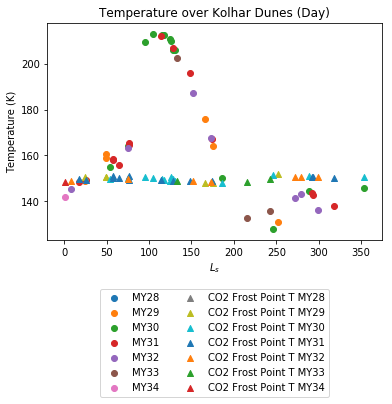

In [126]:
plt.scatter(Kolhar_SubframesDayMY28['L_s'], Kolhar_SubframesDayMY28['T_surf'], label = 'MY28')
plt.scatter(Kolhar_SubframesDayMY29['L_s'], Kolhar_SubframesDayMY29['T_surf'], label = 'MY29')
plt.scatter(Kolhar_SubframesDayMY30['L_s'], Kolhar_SubframesDayMY30['T_surf'], label = 'MY30')
plt.scatter(Kolhar_SubframesDayMY31['L_s'], Kolhar_SubframesDayMY31['T_surf'], label = 'MY31')
plt.scatter(Kolhar_SubframesDayMY32['L_s'], Kolhar_SubframesDayMY32['T_surf'], label = 'MY32')
plt.scatter(Kolhar_SubframesDayMY33['L_s'], Kolhar_SubframesDayMY33['T_surf'], label = 'MY33')
plt.scatter(Kolhar_SubframesDayMY34['L_s'], Kolhar_SubframesDayMY34['T_surf'], label = 'MY34')
plt.scatter(Kolhar_CO2day28['L_s'],Kolhar_CO2day28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.scatter(Kolhar_CO2day29['L_s'],Kolhar_CO2day29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.scatter(Kolhar_CO2day30['L_s'],Kolhar_CO2day30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.scatter(Kolhar_CO2day31['L_s'],Kolhar_CO2day31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.scatter(Kolhar_CO2day32['L_s'],Kolhar_CO2day32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.scatter(Kolhar_CO2day33['L_s'],Kolhar_CO2day33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.scatter(Kolhar_CO2day34['L_s'],Kolhar_CO2day34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.title('Temperature over Kolhar Dunes (Day)')
#plt.xlim(250,300)
#plt.ylim(130,180)
plt.show()

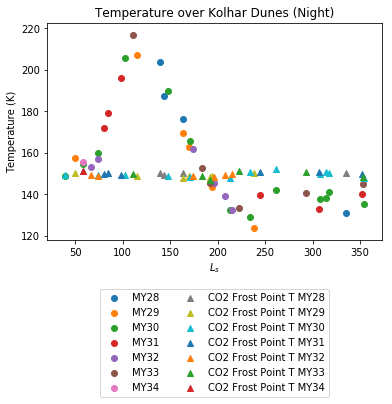

In [125]:
plt.scatter(Kolhar_SubframesNightMY28['L_s'], Kolhar_SubframesNightMY28['T_surf'], label = 'MY28')
plt.scatter(Kolhar_SubframesNightMY29['L_s'], Kolhar_SubframesNightMY29['T_surf'], label = 'MY29')
plt.scatter(Kolhar_SubframesNightMY30['L_s'], Kolhar_SubframesNightMY30['T_surf'], label = 'MY30')
plt.scatter(Kolhar_SubframesNightMY31['L_s'], Kolhar_SubframesNightMY31['T_surf'], label = 'MY31')
plt.scatter(Kolhar_SubframesNightMY32['L_s'], Kolhar_SubframesNightMY32['T_surf'], label = 'MY32')
plt.scatter(Kolhar_SubframesNightMY33['L_s'], Kolhar_SubframesNightMY33['T_surf'], label = 'MY33')
plt.scatter(Kolhar_SubframesNightMY34['L_s'], Kolhar_SubframesNightMY34['T_surf'], label = 'MY34')
plt.scatter(Kolhar_CO2night28['L_s'],Kolhar_CO2night28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.scatter(Kolhar_CO2night29['L_s'],Kolhar_CO2night29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.scatter(Kolhar_CO2night30['L_s'],Kolhar_CO2night30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.scatter(Kolhar_CO2night31['L_s'],Kolhar_CO2night31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.scatter(Kolhar_CO2night32['L_s'],Kolhar_CO2night32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.scatter(Kolhar_CO2night33['L_s'],Kolhar_CO2night33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.scatter(Kolhar_CO2night34['L_s'],Kolhar_CO2night34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Kolhar Dunes (Night)')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.show()

In [135]:
Tleilax_SubframesDayMY28 = CreateSubFrame(dfday28, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.0,85.0), RanLong=np.linspace(-61.9,-60.9))
Tleilax_SubframesDayMY29 = CreateSubFrame(dfday29, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.0,85.0), RanLong=np.linspace(-61.9,-60.9))
Tleilax_SubframesDayMY30 = CreateSubFrame(dfday30, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.0,85.0), RanLong=np.linspace(-61.9,-60.9))
Tleilax_SubframesDayMY31 = CreateSubFrame(dfday31, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.0,85.0), RanLong=np.linspace(-61.9,-60.9))
Tleilax_SubframesDayMY32 = CreateSubFrame(dfday32, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.0,85.0), RanLong=np.linspace(-61.9,-60.9))
Tleilax_SubframesDayMY33 = CreateSubFrame(dfday33, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.0,85.0), RanLong=np.linspace(-61.9,-60.9))
Tleilax_SubframesDayMY34 = CreateSubFrame(dfday34, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.0,85.0), RanLong=np.linspace(-61.9,-60.9))

Tleilax_SubframesNightMY28 = CreateSubFrame(dfnight28, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.0,85.0), RanLong=np.linspace(-61.9,-60.9))
Tleilax_SubframesNightMY29 = CreateSubFrame(dfnight29, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.0,85.0), RanLong=np.linspace(-61.9,-60.9))
Tleilax_SubframesNightMY30 = CreateSubFrame(dfnight30, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.0,85.0), RanLong=np.linspace(-61.9,-60.9))
Tleilax_SubframesNightMY31 = CreateSubFrame(dfnight31, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.0,85.0), RanLong=np.linspace(-61.9,-60.9))
Tleilax_SubframesNightMY32 = CreateSubFrame(dfnight32, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.0,85.0), RanLong=np.linspace(-61.9,-60.9))
Tleilax_SubframesNightMY33 = CreateSubFrame(dfnight33, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.0,85.0), RanLong=np.linspace(-61.9,-60.9))
Tleilax_SubframesNightMY34 = CreateSubFrame(dfnight34, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.0,85.0), RanLong=np.linspace(-61.9,-60.9))

Tleilax_CO2day28 = CreateSubFrame(CO2day28, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.0,85.0), RanLong=np.linspace(-61.9,-60.9))
Tleilax_CO2day29 = CreateSubFrame(CO2day29, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.0,85.0), RanLong=np.linspace(-61.9,-60.9))
Tleilax_CO2day30 = CreateSubFrame(CO2day30, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.0,85.0), RanLong=np.linspace(-61.9,-60.9))
Tleilax_CO2day31 = CreateSubFrame(CO2day31, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.0,85.0), RanLong=np.linspace(-61.9,-60.9))
Tleilax_CO2day32 = CreateSubFrame(CO2day32, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.0,85.0), RanLong=np.linspace(-61.9,-60.9))
Tleilax_CO2day33 = CreateSubFrame(CO2day33, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.0,85.0), RanLong=np.linspace(-61.9,-60.9))
Tleilax_CO2day34 = CreateSubFrame(CO2day34, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.0,85.0), RanLong=np.linspace(-61.9,-60.9))

Tleilax_CO2night28 = CreateSubFrame(CO2night28, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.0,85.0), RanLong=np.linspace(-61.9,-60.9))
Tleilax_CO2night29 = CreateSubFrame(CO2night29, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.0,85.0), RanLong=np.linspace(-61.9,-60.9))
Tleilax_CO2night30 = CreateSubFrame(CO2night30, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.0,85.0), RanLong=np.linspace(-61.9,-60.9))
Tleilax_CO2night31 = CreateSubFrame(CO2night31, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.0,85.0), RanLong=np.linspace(-61.9,-60.9))
Tleilax_CO2night32 = CreateSubFrame(CO2night32, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.0,85.0), RanLong=np.linspace(-61.9,-60.9))
Tleilax_CO2night33 = CreateSubFrame(CO2night33, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.0,85.0), RanLong=np.linspace(-61.9,-60.9))
Tleilax_CO2night34 = CreateSubFrame(CO2night34, RanL_s=np.linspace(0,360), RanLat=np.linspace(84.0,85.0), RanLong=np.linspace(-61.9,-60.9))

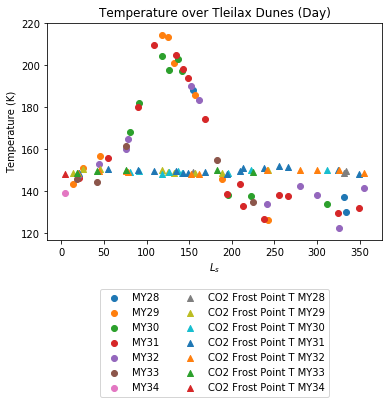

In [136]:
plt.scatter(Tleilax_SubframesDayMY28['L_s'], Tleilax_SubframesDayMY28['T_surf'], label = 'MY28')
plt.scatter(Tleilax_SubframesDayMY29['L_s'], Tleilax_SubframesDayMY29['T_surf'], label = 'MY29')
plt.scatter(Tleilax_SubframesDayMY30['L_s'], Tleilax_SubframesDayMY30['T_surf'], label = 'MY30')
plt.scatter(Tleilax_SubframesDayMY31['L_s'], Tleilax_SubframesDayMY31['T_surf'], label = 'MY31')
plt.scatter(Tleilax_SubframesDayMY32['L_s'], Tleilax_SubframesDayMY32['T_surf'], label = 'MY32')
plt.scatter(Tleilax_SubframesDayMY33['L_s'], Tleilax_SubframesDayMY33['T_surf'], label = 'MY33')
plt.scatter(Tleilax_SubframesDayMY34['L_s'], Tleilax_SubframesDayMY34['T_surf'], label = 'MY34')
plt.scatter(Tleilax_CO2day28['L_s'],Tleilax_CO2day28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.scatter(Tleilax_CO2day29['L_s'],Tleilax_CO2day29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.scatter(Tleilax_CO2day30['L_s'],Tleilax_CO2day30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.scatter(Tleilax_CO2day31['L_s'],Tleilax_CO2day31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.scatter(Tleilax_CO2day32['L_s'],Tleilax_CO2day32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.scatter(Tleilax_CO2day33['L_s'],Tleilax_CO2day33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.scatter(Tleilax_CO2day34['L_s'],Tleilax_CO2day34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.title('Temperature over Tleilax Dunes (Day)')
#plt.xlim(250,300)
#plt.ylim(130,180)
plt.show()

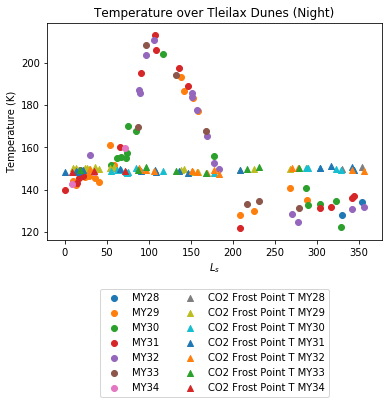

In [137]:
plt.scatter(Tleilax_SubframesNightMY28['L_s'], Tleilax_SubframesNightMY28['T_surf'], label = 'MY28')
plt.scatter(Tleilax_SubframesNightMY29['L_s'], Tleilax_SubframesNightMY29['T_surf'], label = 'MY29')
plt.scatter(Tleilax_SubframesNightMY30['L_s'], Tleilax_SubframesNightMY30['T_surf'], label = 'MY30')
plt.scatter(Tleilax_SubframesNightMY31['L_s'], Tleilax_SubframesNightMY31['T_surf'], label = 'MY31')
plt.scatter(Tleilax_SubframesNightMY32['L_s'], Tleilax_SubframesNightMY32['T_surf'], label = 'MY32')
plt.scatter(Tleilax_SubframesNightMY33['L_s'], Tleilax_SubframesNightMY33['T_surf'], label = 'MY33')
plt.scatter(Tleilax_SubframesNightMY34['L_s'], Tleilax_SubframesNightMY34['T_surf'], label = 'MY34')
plt.scatter(Tleilax_CO2night28['L_s'],Tleilax_CO2night28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.scatter(Tleilax_CO2night29['L_s'],Tleilax_CO2night29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.scatter(Tleilax_CO2night30['L_s'],Tleilax_CO2night30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.scatter(Tleilax_CO2night31['L_s'],Tleilax_CO2night31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.scatter(Tleilax_CO2night32['L_s'],Tleilax_CO2night32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.scatter(Tleilax_CO2night33['L_s'],Tleilax_CO2night33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.scatter(Tleilax_CO2night34['L_s'],Tleilax_CO2night34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Tleilax Dunes (Night)')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.show()

In [133]:
Palma_SubframesDayMY28 = CreateSubFrame(dfday28, RanL_s=np.linspace(0,360), RanLat=np.linspace(75.7,76.7), RanLong=np.linspace(-85.1,-84.1))
Palma_SubframesDayMY29 = CreateSubFrame(dfday29, RanL_s=np.linspace(0,360), RanLat=np.linspace(75.7,76.7), RanLong=np.linspace(-85.1,-84.1))
Palma_SubframesDayMY30 = CreateSubFrame(dfday30, RanL_s=np.linspace(0,360), RanLat=np.linspace(75.7,76.7), RanLong=np.linspace(-85.1,-84.1))
Palma_SubframesDayMY31 = CreateSubFrame(dfday31, RanL_s=np.linspace(0,360), RanLat=np.linspace(75.7,76.7), RanLong=np.linspace(-85.1,-84.1))
Palma_SubframesDayMY32 = CreateSubFrame(dfday32, RanL_s=np.linspace(0,360), RanLat=np.linspace(75.7,76.7), RanLong=np.linspace(-85.1,-84.1))
Palma_SubframesDayMY33 = CreateSubFrame(dfday33, RanL_s=np.linspace(0,360), RanLat=np.linspace(75.7,76.7), RanLong=np.linspace(-85.1,-84.1))
Palma_SubframesDayMY34 = CreateSubFrame(dfday34, RanL_s=np.linspace(0,360), RanLat=np.linspace(75.7,76.7), RanLong=np.linspace(-85.1,-84.1))

Palma_SubframesNightMY28 = CreateSubFrame(dfnight28, RanL_s=np.linspace(0,360), RanLat=np.linspace(75.7,76.7), RanLong=np.linspace(-85.1,-84.1))
Palma_SubframesNightMY29 = CreateSubFrame(dfnight29, RanL_s=np.linspace(0,360), RanLat=np.linspace(75.7,76.7), RanLong=np.linspace(-85.1,-84.1))
Palma_SubframesNightMY30 = CreateSubFrame(dfnight30, RanL_s=np.linspace(0,360), RanLat=np.linspace(75.7,76.7), RanLong=np.linspace(-85.1,-84.1))
Palma_SubframesNightMY31 = CreateSubFrame(dfnight31, RanL_s=np.linspace(0,360), RanLat=np.linspace(75.7,76.7), RanLong=np.linspace(-85.1,-84.1))
Palma_SubframesNightMY32 = CreateSubFrame(dfnight32, RanL_s=np.linspace(0,360), RanLat=np.linspace(75.7,76.7), RanLong=np.linspace(-85.1,-84.1))
Palma_SubframesNightMY33 = CreateSubFrame(dfnight33, RanL_s=np.linspace(0,360), RanLat=np.linspace(75.7,76.7), RanLong=np.linspace(-85.1,-84.1))
Palma_SubframesNightMY34 = CreateSubFrame(dfnight34, RanL_s=np.linspace(0,360), RanLat=np.linspace(75.7,76.7), RanLong=np.linspace(-85.1,-84.1))

Palma_CO2day28 = CreateSubFrame(CO2day28, RanL_s=np.linspace(0,360), RanLat=np.linspace(75.7,76.7), RanLong=np.linspace(-85.1,-84.1))
Palma_CO2day29 = CreateSubFrame(CO2day29, RanL_s=np.linspace(0,360), RanLat=np.linspace(75.7,76.7), RanLong=np.linspace(-85.1,-84.1))
Palma_CO2day30 = CreateSubFrame(CO2day30, RanL_s=np.linspace(0,360), RanLat=np.linspace(75.7,76.7), RanLong=np.linspace(-85.1,-84.1))
Palma_CO2day31 = CreateSubFrame(CO2day31, RanL_s=np.linspace(0,360), RanLat=np.linspace(75.7,76.7), RanLong=np.linspace(-85.1,-84.1))
Palma_CO2day32 = CreateSubFrame(CO2day32, RanL_s=np.linspace(0,360), RanLat=np.linspace(75.7,76.7), RanLong=np.linspace(-85.1,-84.1))
Palma_CO2day33 = CreateSubFrame(CO2day33, RanL_s=np.linspace(0,360), RanLat=np.linspace(75.7,76.7), RanLong=np.linspace(-85.1,-84.1))
Palma_CO2day34 = CreateSubFrame(CO2day34, RanL_s=np.linspace(0,360), RanLat=np.linspace(75.7,76.7), RanLong=np.linspace(-85.1,-84.1))

Palma_CO2night28 = CreateSubFrame(CO2night28, RanL_s=np.linspace(0,360), RanLat=np.linspace(75.7,76.7), RanLong=np.linspace(-85.1,-84.1))
Palma_CO2night29 = CreateSubFrame(CO2night29, RanL_s=np.linspace(0,360), RanLat=np.linspace(75.7,76.7), RanLong=np.linspace(-85.1,-84.1))
Palma_CO2night30 = CreateSubFrame(CO2night30, RanL_s=np.linspace(0,360), RanLat=np.linspace(75.7,76.7), RanLong=np.linspace(-85.1,-84.1))
Palma_CO2night31 = CreateSubFrame(CO2night31, RanL_s=np.linspace(0,360), RanLat=np.linspace(75.7,76.7), RanLong=np.linspace(-85.1,-84.1))
Palma_CO2night32 = CreateSubFrame(CO2night32, RanL_s=np.linspace(0,360), RanLat=np.linspace(75.7,76.7), RanLong=np.linspace(-85.1,-84.1))
Palma_CO2night33 = CreateSubFrame(CO2night33, RanL_s=np.linspace(0,360), RanLat=np.linspace(75.7,76.7), RanLong=np.linspace(-85.1,-84.1))
Palma_CO2night34 = CreateSubFrame(CO2night34, RanL_s=np.linspace(0,360), RanLat=np.linspace(75.7,76.7), RanLong=np.linspace(-85.1,-84.1))

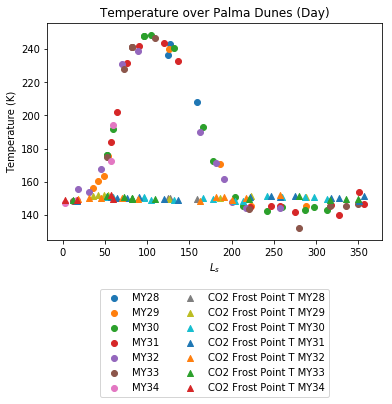

In [134]:
plt.scatter(Palma_SubframesDayMY28['L_s'], Palma_SubframesDayMY28['T_surf'], label = 'MY28')
plt.scatter(Palma_SubframesDayMY29['L_s'], Palma_SubframesDayMY29['T_surf'], label = 'MY29')
plt.scatter(Palma_SubframesDayMY30['L_s'], Palma_SubframesDayMY30['T_surf'], label = 'MY30')
plt.scatter(Palma_SubframesDayMY31['L_s'], Palma_SubframesDayMY31['T_surf'], label = 'MY31')
plt.scatter(Palma_SubframesDayMY32['L_s'], Palma_SubframesDayMY32['T_surf'], label = 'MY32')
plt.scatter(Palma_SubframesDayMY33['L_s'], Palma_SubframesDayMY33['T_surf'], label = 'MY33')
plt.scatter(Palma_SubframesDayMY34['L_s'], Palma_SubframesDayMY34['T_surf'], label = 'MY34')
plt.scatter(Palma_CO2day28['L_s'],Palma_CO2day28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.scatter(Palma_CO2day29['L_s'],Palma_CO2day29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.scatter(Palma_CO2day30['L_s'],Palma_CO2day30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.scatter(Palma_CO2day31['L_s'],Palma_CO2day31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.scatter(Palma_CO2day32['L_s'],Palma_CO2day32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.scatter(Palma_CO2day33['L_s'],Palma_CO2day33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.scatter(Palma_CO2day34['L_s'],Palma_CO2day34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.title('Temperature over Palma Dunes (Day)')
#plt.xlim(250,300)
#plt.ylim(130,180)
plt.show()

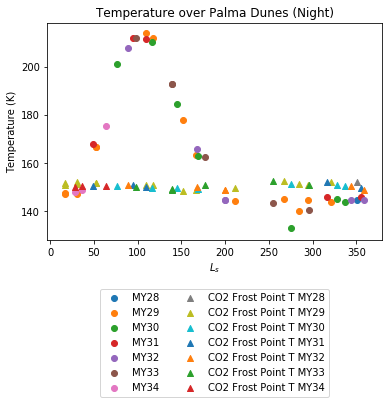

In [122]:
plt.scatter(Palma_SubframesNightMY28['L_s'], Palma_SubframesNightMY28['T_surf'], label = 'MY28')
plt.scatter(Palma_SubframesNightMY29['L_s'], Palma_SubframesNightMY29['T_surf'], label = 'MY29')
plt.scatter(Palma_SubframesNightMY30['L_s'], Palma_SubframesNightMY30['T_surf'], label = 'MY30')
plt.scatter(Palma_SubframesNightMY31['L_s'], Palma_SubframesNightMY31['T_surf'], label = 'MY31')
plt.scatter(Palma_SubframesNightMY32['L_s'], Palma_SubframesNightMY32['T_surf'], label = 'MY32')
plt.scatter(Palma_SubframesNightMY33['L_s'], Palma_SubframesNightMY33['T_surf'], label = 'MY33')
plt.scatter(Palma_SubframesNightMY34['L_s'], Palma_SubframesNightMY34['T_surf'], label = 'MY34')
plt.scatter(Palma_CO2night28['L_s'],Palma_CO2night28['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY28')
plt.scatter(Palma_CO2night29['L_s'],Palma_CO2night29['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY29')
plt.scatter(Palma_CO2night30['L_s'],Palma_CO2night30['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY30')
plt.scatter(Palma_CO2night31['L_s'],Palma_CO2night31['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY31')
plt.scatter(Palma_CO2night32['L_s'],Palma_CO2night32['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY32')
plt.scatter(Palma_CO2night33['L_s'],Palma_CO2night33['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY33')
plt.scatter(Palma_CO2night34['L_s'],Palma_CO2night34['Eq_Vap_T'], marker = '^', label= 'CO2 Frost Point T MY34')
plt.xlabel('${L_s}$')
plt.ylabel('Temperature (K)')
plt.title('Temperature over Palma Dunes (Night)')
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2), ncol=2)
plt.show()